In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import librosa
import librosa.display
import re
from sklearn.model_selection import train_test_split
import keras

In [2]:
ds_dir = '/arch/mnist_data'
filenames = []

for root, dirs, files in os.walk(ds_dir):
    for file in files:
        filenames.append(os.path.join(root,file))
filenames = [re.sub(r'(\\)', '/', name) for name in filenames[1:]]

samples_number = len(filenames)
print('Total number of samples:', samples_number)

Total number of samples: 30000


In [3]:
labels = np.array(["zero","one","two","three","four","five","6","7","8","9"])
train_files,test_files = train_test_split(filenames, test_size=0.2, shuffle=True)

print('Training data size', len(train_files))
print('Test data size', len(test_files))

Training data size 24000
Test data size 6000


In [4]:
def get_label(file_path):
    label = re.findall(r'/([0-9])_', file_path)[0]
    label_id = np.array([np.argmax(label == labels)])
    return label_id

In [5]:
y, sr = librosa.load(test_files[0])
y,sr

(array([-7.37610026e-05, -2.04616255e-04, -1.77224880e-04, ...,
        -1.11792324e-04, -1.12043519e-04,  0.00000000e+00], dtype=float32),
 22050)

In [6]:
def get_ms(file_path):
    return file_path

In [7]:
input_shape = (128,44)

In [8]:
def preprocess_dataset(files):
    output_labels = [get_label(file) for file in files]
    output_ms = [get_ms(file) for file in files]
    return output_ms, output_labels

In [9]:
train_ms,train_labels = preprocess_dataset(train_files[:12])
#test_ms,test_labels = preprocess_dataset(test_files)

In [10]:
import matplotlib as mpl

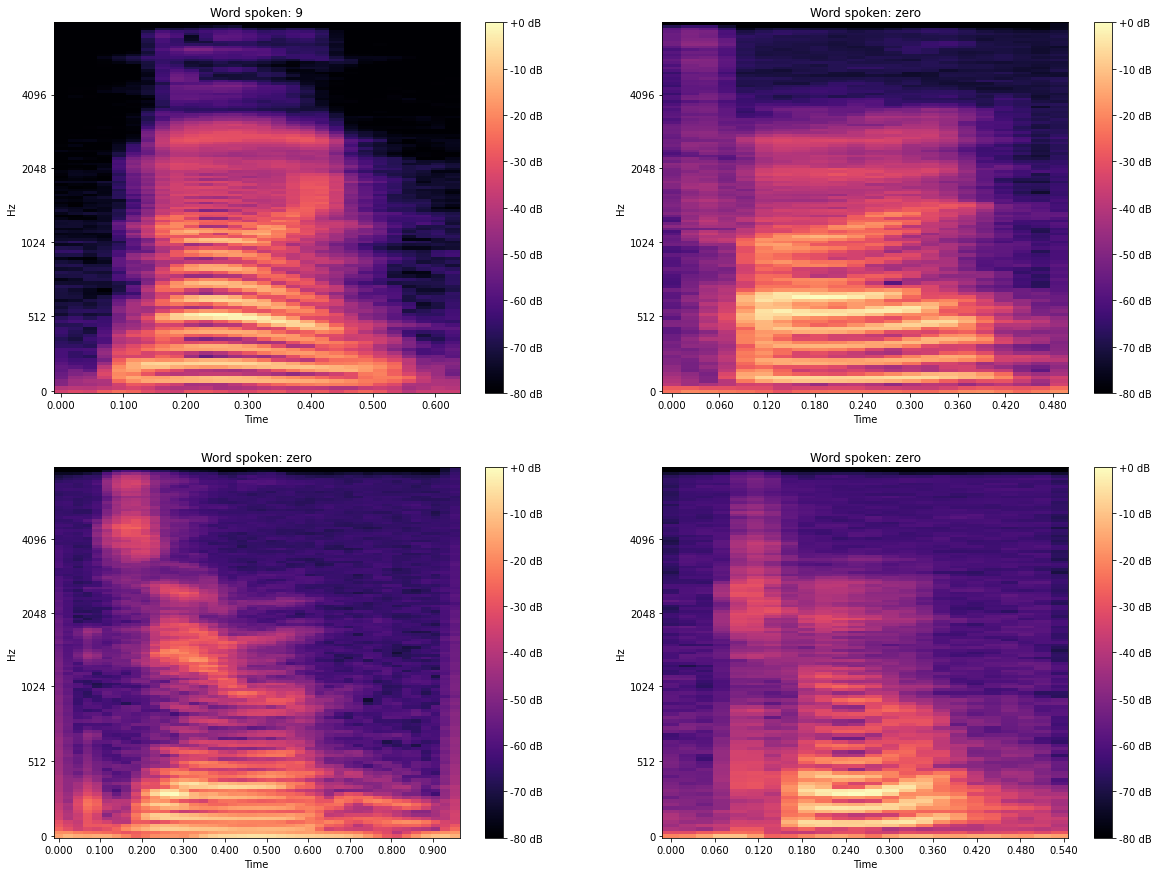

In [20]:
rows = 2
cols = 2
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))

for i, (file, label) in enumerate(zip(train_ms[:n], train_labels[:n])):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    y, sr = librosa.load(file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=512)
    #ms = np.resize(ms, input_shape)
    ms_dB = librosa.power_to_db(ms, ref=np.max)
    image = librosa.display.specshow(ms_dB, x_axis='time',
                         y_axis='mel', sr=22050,
                         fmax=8000, ax=ax)
    fig.colorbar(image, ax=ax, format='%+2.0f dB')
    ax.set_title("Word spoken: {}".format(labels[label][0]))

plt.show()

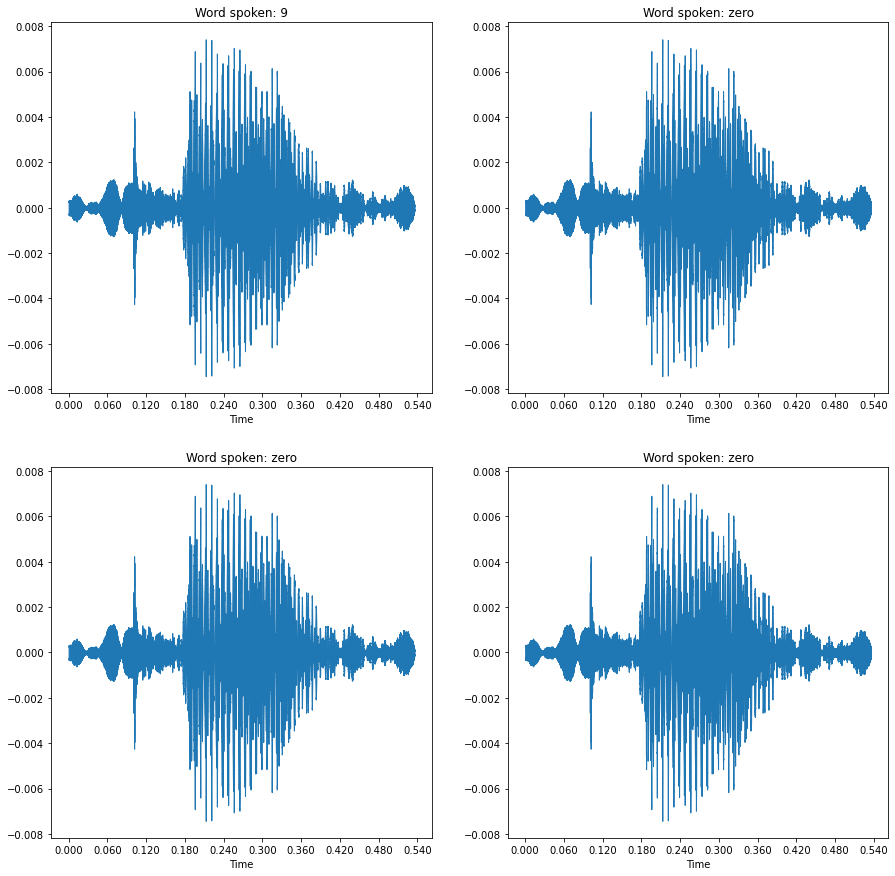

In [18]:
rows = 2
cols = 2
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

for i, (ms, label) in enumerate(zip(train_ms[:n], train_labels[:n])):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    y, sr = librosa.load(file)
    librosa.display.waveshow(y, sr=sr, x_axis='time', ax=ax)
    ax.set_title("Word spoken: {}".format(labels[label][0]))

plt.show()

In [ ]:
max = np.max([i.shape[1] for i in train_ms])
input_shape = (train_ms[0].shape[0], max)
print(input_shape)

(128, 44)


In [ ]:
train_ms = np.array([np.resize(i, input_shape) for i in train_ms])
train_labels = np.array(train_labels)

test_ms = np.array([np.resize(i, input_shape) for i in test_ms])
test_labels = np.array(test_labels)

In [ ]:
feature_normalizer = tf.keras.layers.Normalization(axis=None,input_shape=(1,)) 
feature_normalizer.adapt(train_ms)

num_labels = len(labels)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(128,44,1)),
    tf.keras.layers.Resizing(32, 32),
    feature_normalizer,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_labels),
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_2 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 64)       

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 20
history = model.fit(
    train_ms, train_labels,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=64,
    verbose = 1)

Epoch 1/20
300/300 [==============================] - 69s 229ms/step - loss: 1.7886 - accuracy: 0.3653 - val_loss: 1.2868 - val_accuracy: 0.5721
Epoch 2/20
300/300 [==============================] - 69s 229ms/step - loss: 1.2286 - accuracy: 0.5651 - val_loss: 0.9656 - val_accuracy: 0.6800
Epoch 3/20
300/300 [==============================] - 69s 230ms/step - loss: 1.0116 - accuracy: 0.6398 - val_loss: 0.8436 - val_accuracy: 0.7075
Epoch 4/20
300/300 [==============================] - 69s 229ms/step - loss: 0.8728 - accuracy: 0.6865 - val_loss: 0.7579 - val_accuracy: 0.7348
Epoch 5/20
300/300 [==============================] - 69s 229ms/step - loss: 0.7974 - accuracy: 0.7150 - val_loss: 0.7043 - val_accuracy: 0.7517
Epoch 6/20
300/300 [==============================] - 69s 229ms/step - loss: 0.7369 - accuracy: 0.7361 - val_loss: 0.6205 - val_accuracy: 0.7848
Epoch 7/20
300/300 [==============================] - 69s 230ms/step - loss: 0.6614 - accuracy: 0.7639 - val_loss: 0.5843 - val_ac

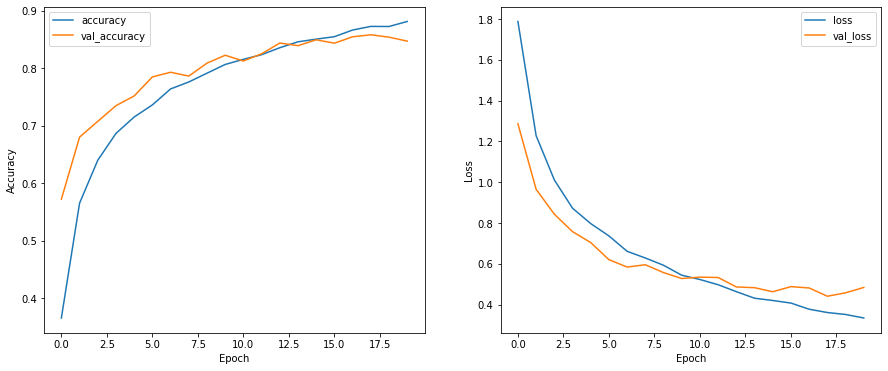

In [ ]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(history.history['accuracy'], label='accuracy')
ax1.plot(history.history['val_accuracy'], label = 'val_accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='loss')
ax2.plot(history.history['val_loss'], label='val_loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_ms,  test_labels, verbose=2)
print ("Accuracy {:.2%}".format(test_acc))

188/188 - 5s - loss: 0.4974 - accuracy: 0.8493 - 5s/epoch - 29ms/step
Accuracy 84.93%


In [ ]:
y_pred = np.argmax(model.predict(test_ms), axis=1)
y_true = test_labels

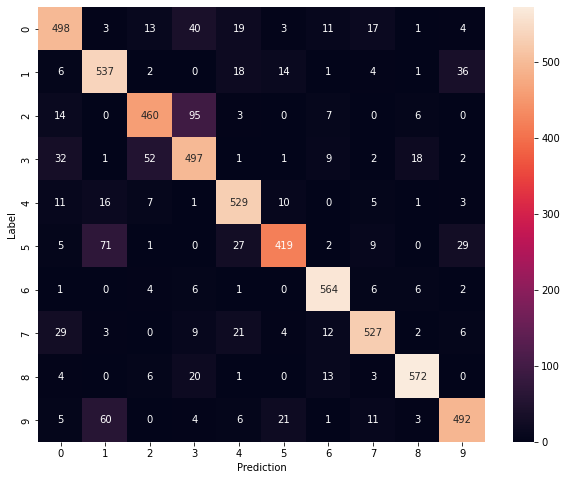

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# хрень не знаю зачем

In [68]:
def show_mel(file):
    fig, ax = plt.subplots(figsize=(7, 5))
    ms = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=512)
    ms_dB = librosa.power_to_db(ms, ref=np.max)
    image = librosa.display.specshow(ms_dB, x_axis='time',
                         y_axis='mel', sr=22050,
                         fmax=8000)
    fig.colorbar(image, ax=ax, format='%+2.0f dB')
    ax.set_title("Word spoken: {}".format(test_label[0]))
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1f}'))

    plt.show()

In [40]:
model = keras.models.load_model("models/densenet169_weights", compile=False)

In [23]:
test_files[0]

'/arch/mnist_data/15/6_15_6.wav'

In [49]:
test_ms,test_label = get_ms(test_files[0], input_shape), get_label(test_files[0])

In [50]:
test_ms = test_ms[None, :]
test_ms.shape

(1, 128, 44, 3)

In [56]:
pred_label = model.predict(test_ms)
print(pred_label)
print('Истинный класс: ',test_label[0],'\nПредсказание модели: ',np.argmax(pred_label))

1/1 [==============================] - 0s 56ms/step
[[ -6.543807  -14.927246   -8.291641   -1.8065976  -3.3888516   1.2404
   26.03896    10.682668    5.8124537 -11.550231 ]]
Истинный класс:  6 
Предсказание модели:  6


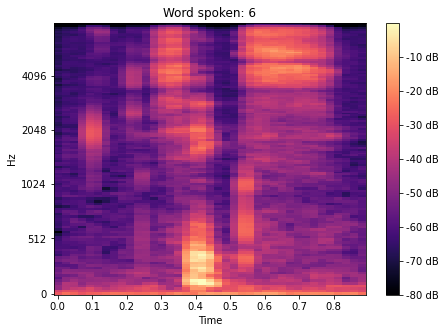

In [69]:
show_mel(test_files[0])